# Examples

Last updated: July 12, 2017

Below are a few examples to get you started.


In [1]:
import numpy as np
import matplotlib.pyplot as plt


from ftperiodogram.modeler import FastTemplatePeriodogram, FastMultiTemplatePeriodogram, TemplateModel
from ftperiodogram.template import Template
from ftperiodogram.utils import ModelFitParams

rand = np.random

## The `Template` class

There are two ways of instantiating the `Template` class, which is needed by both the `FastTemplatePeriodogram` and `FastMultiTemplatePeriodogram` classes.

### If you have a template defined by `phase`, `y_phase`, use the `.from_sampled` class method to instantiate:

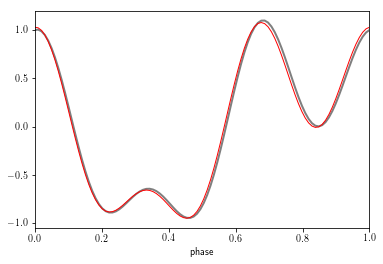

In [2]:
# Make a template
phase = np.linspace(0, 1, 100)

amps   = [ 0.5, 0.2, 0.3 ]
phases = [ -1., 1.3, 0.2 ]

amps = np.array(amps) / np.sqrt(sum(np.power(amps, 2)))
y_phase = sum([ a * np.cos(2 * (n+1) * np.pi * phase - p) \
                for n, (a,p) in enumerate(zip(amps, phases)) ])


# Instantiate the `Template` class
our_template = Template.from_sampled(y_phase, nharmonics=3)

# Plot a comparison
f, ax = plt.subplots()

ax.plot(phase, y_phase, color='k', lw=2, alpha=0.5)
ax.plot(phase, our_template(phase), color='r')
ax.set_xlabel('phase')
ax.set_xlim(0,1)
plt.show()


### If you know the Fourier coefficients of the template: 

In [3]:
# Obtain the Fourier coefficients from the last template fit
c_n, s_n = our_template.c_n, our_template.s_n

# Instantiate a new `Template` using coefficients
new_template = Template(c_n, s_n)

# Check that both templates are equivalent
print(all(new_template(phase) == our_template(phase)))


True


## The `TemplateModel` class

The `TemplateModel` class stores a template and a set of fit parameters. When called, the model will return

$\hat{y}(t) = aM(\omega(t - \tau)) + c$

where $M(\phi)$ is the template, and $a, \omega, \tau, c$ are the fit parameters. The parameters must be an instance of `ModelFitParams`, which is simply an ordered dictionary with the attributes `a`, `b`, `c`, `sgn`. The `b` and `sgn` variables represent $\cos(\omega \tau)$ and ${\rm sign}(sin(\omega\tau))$, respectively.

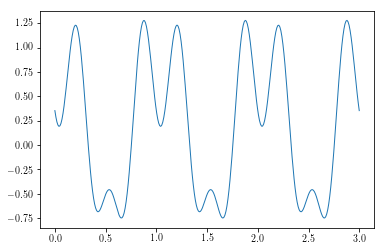

In [4]:
# set some model parameters (arbitrary)
params = ModelFitParams(a=1., b=0.3, c=0.2, sgn=1)

# 
model = TemplateModel(our_template, frequency=1.0, parameters=params)

t = np.linspace(0, 3, 300)
y0 = model(t)
f, ax = plt.subplots()
ax.plot(t, y0)
plt.show()

## Template periodogram, single template -- `FastTemplatePeriodogram`

The `FastTemplatePeriodogram` can be used to fit a (single) periodic template to irregularly sampled time-series data at a number of frequencies.

### Accessing the best-fit model

After running `power` or `autopower`, the `FastTemplatePeriodogram` will keep the best-fit model in the form of a `TemplateModel` instance accessible via the `.best_model` attribute.

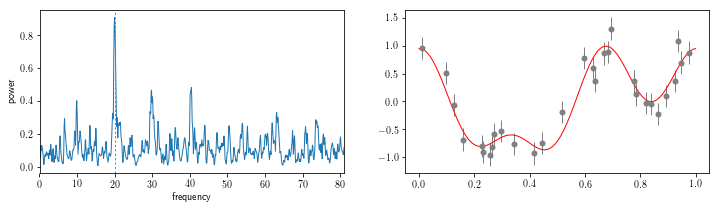

In [5]:
# Instantiate periodogram with template
ftp = FastTemplatePeriodogram(template=our_template)

# Generate random data (using template)
ndata = 30
sigma = 0.2
freq = 20.

t = np.sort(rand.rand(ndata))
phi = (t * freq) % 1.0

y = ftp.template(phi) + sigma * rand.randn(ndata)
yerr = sigma * np.ones_like(y)

# Provide periodogram with data
ftp.fit(t, y, yerr)

# Produce a periodogram over an automatically-determined
# set of frequencies for the given template
freqs, powers = ftp.autopower(samples_per_peak=10)

f, (axper, axfit) = plt.subplots(1, 2, figsize=(12, 3))

best_freq = freqs[np.argmax(powers)]

# Plot periodogram
axper.plot(freqs, powers)
axper.axvline(freq, ls=':', color='0.5')
axper.set_xlabel('frequency')
axper.set_ylabel('power')
axper.set_xlim(min(freqs), max(freqs))

# Plot data
axfit.errorbar((t * best_freq) % 1.0, y, yerr, fmt='o', c='0.5')
axfit.plot(phase, ftp.best_model(phase / best_freq), color='r')
plt.show()


## Template periodogram, multiple templates -- `FastMultiTemplatePeriodogram`

If you would like to fit from a selection of templates, you may do so via the `FastMultiTemplatePeriodogram`. At each trial frequency, the `FastMultiTemplatePeriodogram` will pick the template that best fits the data. This is useful for detecting classes of objects that exhibit multiple kinds of periodic fluctuations (for example, RR Lyrae).

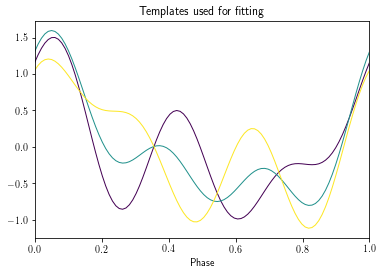

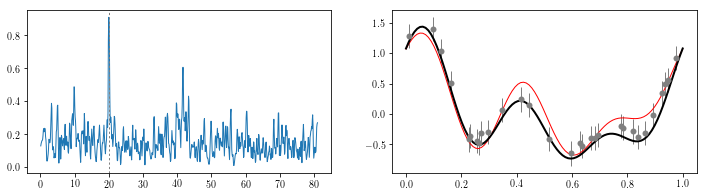

In [6]:
# Make two templates
cn1, sn1 = zip(*[ (0.2, 0.2), (0.0, 0.2), (0.2, 0.0) ])
cn2, sn2 = zip(*[ (0.2, 0.1), (0.2, 0.0), (0.0, 0.2) ])
template1 = Template(cn1, sn1)
template2 = Template(cn2, sn2)


# Now, generate some linear combinations of the templates
y_temp1   = template1(phase)
y_temp2   = template2(phase)

signal = lambda x, q=0.5 :  q * template1(x) + (1 - q) * template2(x)

templates = []

ftemp, axtemp = plt.subplots()
colormap = plt.get_cmap('viridis')
axtemp.set_title('Templates used for fitting')
axtemp.set_xlabel('Phase')
for q in [ 0.0, 0.5, 1.0 ]:
    y_temp = signal(phase, q=q)
    templates.append(Template.from_sampled(y_temp, nharmonics=4))
    
    axtemp.plot(phase, templates[-1](phase), color=colormap(q))
    
axtemp.set_xlim(0, 1)

# generate some new data
q_data = 0.25
y_new = signal(phi, q=q_data) + sigma * rand.rand(len(t))

# instantiate (multi-template) periodogram
ftp_multi = FastMultiTemplatePeriodogram(templates=templates)

# give periodogram data
ftp_multi.fit(t, y_new, yerr)

# evaluate periodogram at a set of automatically determined
# frequencies
freqs_multi, powers_multi = ftp_multi.autopower(samples_per_peak = 10)

best_freq = freqs_multi[np.argmax(powers_multi)]

f2, (axper, axfit) = plt.subplots(1, 2, figsize=(12, 3))
axper.plot(freqs_multi, powers_multi)
axper.axvline(freq, ls=':', color='0.5')

axfit.plot(phase, ftp_multi.best_model(phase/best_freq), color='r')
axfit.plot(phase, signal(phase, q=q_data), color='k', lw=2)
axfit.errorbar((t * best_freq) % 1.0, y_new, yerr, fmt='o', c='0.5')

plt.show()



## Single-frequency fits

You may also use either the `FastTemplatePeriodogram` or `FastMultiTemplatePeriodogram` to fit a template at a given frequency using the `fit_model` method.

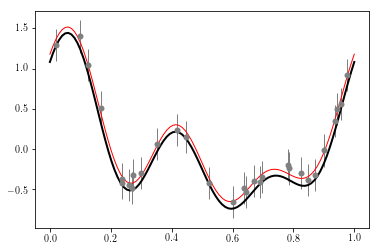

In [7]:
correct_template = Template.from_sampled(signal(phase, q=q_data), nharmonics=4)

another_model = FastTemplatePeriodogram(template=correct_template).fit(t, y_new, yerr).fit_model(freq)

f,ax = plt.subplots()

ax.plot(phase, another_model(phase/freq), color='r')
ax.plot(phase, signal(phase, q=q_data), color='k', lw=2)
ax.errorbar((t * freq) % 1.0, y_new, yerr, fmt='o', c='0.5')

plt.show()